# NBA Game Predictions - Final Report
## Kevin Yang, Eric Lee, Derek Young


## Introduction
The NBA ([National Basketball Association](http://nba.com)) is an American based men's basketball league with, as of recently, 30 teams that each play 82 regular season games. With technology at it's forefront, there has been a growth of data collection on NBA games, teams and players. NBA fans and analysts have access to almost any statistic imaginable that the league collects. Our main objective is to utilize machine learning techniques to predict which team will win each regular season game. We will focus on Linear Regression, Logistic Regression and Support Vector Machines for our predictions.

<a id="Report Contents"></a>
## Report Contents

1. [Data Collection](#Data Collection)
2. [Feature Creation](#Feature Creation)
    1. [Preprocessing Constant Features](#Preprocessing)
    2. [Adding Time-Sensitive Features](#Adding Time-Sesitive Features)
3. [Exploratory Data Analysis](#EDA)
    1. [Univariate Analysis](#Univariate Analysis)
    1. [Bivariate Analysis](#Bivariate Analysis)
    2. [Back-to-back games: Significance](#Back-to-Back)
    3. [The NBA over Time](#The NBA over Time)
4. [Feature Selection](#Feature Selection)
    1. [Training Cutoff](#Training Cutoff)
    2. ["N-Previous Games" Tuning](#N-Previous Games)
5. [Additional Features](#Additional Features)
    1. [Altitude](#Altitude)
    2. [Travel Distance](#Travel Distance)
6. [Modeling](#Modeling)
    1. [Naive Approach](#Naive Approach)
    2. [Linear Regression](#Linear Regression)
    3. [Logistic Regression](#Logistic Regression)
    4. [Support Vector Machines](#SVM)
7. [Concluding Thoughts]()


While most of our project is written in Python, a certain subset was done in R, specifically modeling linear and logistic regression.

<a id='Data Collection'></a>
## 1. Data Collection

We found our data on [stats.nba.com](http://stats.nba.com). First, we surveyed the webpage, finding the location and organization of data. Using Google Chrome Developer Tools, we found link structures and JSON responses containing useful data for our models. Once we developed a scalable approach to get all team game data for any NBA season, we found `sqlite3` to be a consistent and reliable approach, as our data will not change unexpectedly, and we won't overload servers with requests.

In [7]:
import requests
import sqlite3
import pandas as pd

def get_league_gamelogs(season):
    """ Given a season (string, ex: 2016-17), returns a (header, log_list) where the header represents a 
        key describing the format of the logs in log_list
    Input:
        season (str): season string, ex: '2016-17'
    Output:
        (list, dict)
    """
    league_log_url = ("http://stats.nba.com/stats/leaguegamelog?Counter=1000&DateFrom=&DateTo=&" + 
                  "Direction=DESC&LeagueID=00&PlayerOrTeam=T&Season=" + str(season) + 
                  "&SeasonType=Regular+Season&Sorter=PTS")
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; rv:39.0) Gecko/20100101 Firefox/39.0'}

    # Request URL and parse JSON
    response = requests.get(league_log_url, headers = headers)
    response.raise_for_status() # Raise exception if invalid response
    response_json = response.json()
    log_list = response_json['resultSets'][0]['rowSet']
    header = response_json['resultSets'][0]['headers']
    
    return (header, log_list)

def generate_year_list(start, yrs):
    """ Generate a year list to pass into load_all_gamelogs
    Input:
        start (int): The first year we are interested in loading
        yrs (int): How many years since start that we are including
    Output:
        (List): List of years
    """
    year_list = []
    curr_yr = start
    for i in xrange(yrs):
        nextyr = curr_yr + 1 
        year_list.append(str(curr_yr)+"-"+str(nextyr)[2:])
        curr_yr = nextyr
    return year_list
    
def load_all_gamelogs(conn, start, yrs):
    """ Load nba gamelog data for the past yrs years as a games tables into an sqlite database given in conn
    Input:
        conn (sqlite3.Connection): Connection object corresponding to the database; used to perform SQL commands.
        yrs (int): Number of years to include in table
    Output:
        None
    """
    
    cursor = conn.cursor()
    
    year_list = generate_year_list(start,yrs)
    
    # Clear any existing league_log table
    cursor.execute('drop table if exists league_log')
    
    # Create league_log table
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS league_log (
    season_id TEXT, team_id INTEGER, team_abbreviation TEXT, team_name TEXT, game_id INTEGER,
    game_date INTEGER, matchup INTEGER, wl STRING, min INTEGER, fgm INTEGER, fga INTEGER,
    fg_pct REAL, fg3m INTEGER, fg3a INTEGER, fg3_pct REAL, ftm INTEGER, fta INTEGER, ft_pct REAL,
    oreb INTEGER, dreb INTEGER, reb INTEGER, ast INTEGER, stl INTEGER, blk INTEGER, tov INTEGER,
    pf INTEGER, pts INTEGER, plus_minus INTEGER
    )""")
    
    for year in year_list:
        (header, log_list) = get_league_gamelogs(year)
        
        question_marks = "(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ? ,?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"
        query_string = "INSERT INTO league_log VALUES " + question_marks
        for log in log_list:
            cursor.execute(query_string,
                          (log[0],log[1],log[2],log[3],log[4],log[5],log[6],log[7],
                          log[8], log[9], log[10], log[11], log[12], log[13], log[14],
                          log[15],log[16], log[17], log[18], log[19], log[20], log[21],
                          log[22], log[23], log[24], log[25], log[26], log[27]))
            
    conn.commit()

In [4]:
# Connect to database file
conn = sqlite3.connect(r"db/league.db")
conn.text_factory = str

# Define relevant years
start_year = 1946
length = 2017 - start_year

load_all_gamelogs(conn, start_year, length)

# Load newly stored data into pandas DataFrame league_df
league_df = pd.read_sql_query('SELECT * FROM league_log', conn)
league_df.head()

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,fgm,...,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus
0,21946,1610610025,CHS,Chicago Stags,24600208,1947-02-06,CHS vs. PIT,W,0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,109,24
1,21946,1610610025,CHS,Chicago Stags,24600284,1947-03-09,CHS @ CLR,W,0,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,107,30
2,21946,1610610025,CHS,Chicago Stags,24600280,1947-03-08,CHS vs. PRO,W,0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,107,26
3,21946,1610610036,WAS,Washington Capitols,24600199,1947-02-02,WAS @ CLR,W,0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,107,26
4,21946,1610610036,WAS,Washington Capitols,24600320,1947-03-26,WAS vs. CHS,W,0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,105,28


In [5]:
def validate_data(df):
    """ Given a DataFrame of league game logs, performs a few sanity checks based upon the number of games 
        in a season.
    Input:
        df (pd.DataFrame): league game logs
    Output:
        str
    """
    year_list = df['season_id'].unique().tolist()
    
    for year in year_list:
        df_temp = df[df['season_id'] == year]
        
        if year == '22011':
            # Lockout year
            assert(df_temp.shape[0] == 1980)
        elif year == '22016':
            # Current ongoing year
            continue
        elif year >= '22004':
            # Normal 30 team, 82 game schedule
            assert(df_temp.shape[0] == 2460) 
    return "Passed!"

print validate_data(league_df)

Passed!


We have now successfully stored league-log data from `1946-2016`. Further, we have passed some sanity checks to help ensure the correctness of our data. Currently, the league_df contains some NaN values; this is because there is a lack of data on certain older years on `stats.nba.com`. We print out the following to show more recent data (2005-06 season).

In [8]:
(league_df[league_df['season_id'] == "22005"]).head()

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,fgm,...,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus
86522,22005,1610612760,SEA,Seattle SuperSonics,20500589,2006-01-22,SEA @ PHX,W,290,54.0,...,10.0,35.0,45.0,21.0,9.0,3.0,19.0,24.0,152,3
86523,22005,1610612756,PHX,Phoenix Suns,20500589,2006-01-22,PHX vs. SEA,L,290,57.0,...,13.0,27.0,40.0,35.0,6.0,16.0,15.0,30.0,149,-3
86524,22005,1610612756,PHX,Phoenix Suns,20501067,2006-03-31,PHX @ TOR,W,240,51.0,...,8.0,24.0,32.0,37.0,10.0,3.0,8.0,20.0,140,14
86525,22005,1610612752,NYK,New York Knicks,20500438,2006-01-02,NYK vs. PHX,W,315,52.0,...,19.0,44.0,63.0,23.0,12.0,1.0,22.0,27.0,140,7
86526,22005,1610612743,DEN,Denver Nuggets,20500498,2006-01-10,DEN vs. PHX,W,315,51.0,...,12.0,34.0,46.0,27.0,7.0,5.0,17.0,26.0,139,2


<a id='Feature Creation'></a>
## 2. Feature Creation
Before any exploratory data analysis, we need to preprocess our dataframe to include a few new columns. This is because each row in our current dataframe only contains data on postgame stats (i.e. points scored, win/loss), and does not contain any data that can be used as predictors before the game started. Based upon intuition and inspiration from other sources (mainly Amorim Torres [1]) we will add 15 new features, as described in function commments below.

Since the dynamics of NBA teams change from season to season, these features will
be season specific. To create these features, we note that some of the features are not time-sensitive. Thus, we divide the preprocessing into two functions, `add_constant_features` and `add_variable_features`, which add
constant features and the time-sensitive features respectively.

<a id='Preprocessing'></a>
### 2A. Preprocessing Constant Features

In [9]:
import numpy as np

# First add the constant features
def add_constant_features(league_df):
    """ Given a dataframe league_df, returns new league_df by converting the 'game_date' column to datetime if 
    necessary, and adds is_home indicator, opp_team_id, and wl_binary indicator. 
    Input:
        league_df (pandas.DataFrame): dataframe containing league logs
    Output:
        pd.DataFrame with added variables: 1. is_home (1 if the team is playing at home, 0 otherwise)
                                           2. opp_team_id (opposing team identifier)
                                           3. wl_binary (1 if the team won, 0 otherwise)
    """
    # Convert to datetime, note that this is in place
    league_df['game_date'] = league_df['game_date'].apply(pd.to_datetime)
    
    # Add new columns
    is_home = np.zeros(len(league_df), dtype=np.int64)
    opp_team_id = np.zeros(len(league_df), dtype=np.int64)
    wl_binary = np.zeros(len(league_df), dtype = np.int64)
    
    league_df = league_df.assign(is_home = is_home)
    league_df = league_df.assign(opp_team_id = opp_team_id)
    league_df = league_df.assign(wl_binary = wl_binary)
    
    
    # Add home indicator variable
    for (index, row) in league_df.iterrows():
        matchup = row['matchup']
        if "@" in matchup:
            league_df.set_value(index, "is_home", 0)
        else:
            league_df.set_value(index, "is_home", 1)
            
    # Add opposing team ID
    for (index,row) in league_df.iterrows():
        game_id = row['game_id']
        team_id = row['team_id']
        
        # Find other game with the same game ID
        df_game = league_df[league_df['game_id'] == game_id]
        assert(len(df_game) == 2)
        found_opp = False
        for (inner_index,inner_row) in df_game.iterrows():
            curr_team_id = inner_row['team_id']
            if curr_team_id == team_id:
                continue
            else:
                # Found opposing team, update opposing team ID
                league_df.set_value(index, 'opp_team_id', curr_team_id)
                found_opp = True
        assert(found_opp)
        
    # Add binary representation of wins and losses
    for (index, row) in league_df.iterrows():
        wl = row['wl']
        if wl == 'W':
            league_df.set_value(index, 'wl_binary', 1)
        else:
            league_df.set_value(index, 'wl_binary', 0)
    
    return league_df

<a id='Adding Time-Sesitive Features'></a>
### 2B. Adding Time Sensitive Features
We use N = 11 as our lookback parameter (choice of N is discused in the section [4B](#N-Previous Games)).

In [10]:
# Continue adding to our dataframe (4-15 in the list above). 
def add_variable_features(league_df, N=11):
    """ Given a dataframe league_df, returns a new df containing extra columns for each new feature.
        If new_years = true, adds features that only work for data frames containing data >= 2005
    Input:
        league_df (pandas.DataFrame): dataframe containing league logs
        N (int): lookback parameter
    Output:
        pd.DataFrame with added variables: 4. home_win_pct (win percentage of the home team prior to the current game)
                                           5. away_win_pct (win percentage of the away team prior to the current game)
                                           6. home_avg_pt_diff (average pt differential of the home team prior to the current game)
                                           7. away_avg_pt_diff (average pt differential of the away team prior to the current game)
                                           8. home_win_pct_N (win percentage of the home team in last N games prior to the current game)
                                           9. away_win_pct_N (win percentage of the away team in last N games prior to the current game)
                                           10. home_win_pct_as_home (win percentage of the home team as home prior to the current game)
                                           11. away_win_pct_as_away (win percentage of the away team as away prior to the current game)
                                           12. home_back_to_back (1 if the home team just played the day prior, 0 otherwise)
                                           13. away_back_to_back (1 if the away team just played the day prior, 0 otherwise)
                                           14. home_game_count (# games the home team as played prior to the current game)
                                           15. away_game_count (# games the away team as played prior to the current game)
    """    
    lookback = N
    new_df = league_df.sort_values('game_date')
    
    # Add new columns
    home_win_pct = np.zeros(len(new_df))
    away_win_pct = np.zeros(len(new_df))
    home_avg_pt_diff = np.zeros(len(new_df))
    away_avg_pt_diff = np.zeros(len(new_df))
    home_win_pct_N = np.zeros(len(new_df))
    away_win_pct_N = np.zeros(len(new_df))
    away_win_pct_as_away = np.zeros(len(new_df))
    home_win_pct_as_home = np.zeros(len(new_df))
    home_back_to_back = np.zeros(len(new_df))
    away_back_to_back = np.zeros(len(new_df))
    home_game_count = np.zeros(len(new_df))
    away_game_count = np.zeros(len(new_df))
    home_mileage = np.zeros(len(new_df))
    away_mileage = np.zeros(len(new_df))
    
    new_df = new_df.assign(home_win_pct = home_win_pct)
    new_df = new_df.assign(away_win_pct = away_win_pct)
    new_df = new_df.assign(home_avg_pt_diff = home_avg_pt_diff)
    new_df = new_df.assign(away_avg_pt_diff = away_avg_pt_diff)
    new_df = new_df.assign(home_win_pct_N = home_win_pct_N)
    new_df = new_df.assign(away_win_pct_N = away_win_pct_N)
    new_df = new_df.assign(away_win_pct_as_away = away_win_pct_as_away)
    new_df = new_df.assign(home_win_pct_as_home = home_win_pct_as_home)
    new_df = new_df.assign(home_back_to_back = home_back_to_back)
    new_df = new_df.assign(away_back_to_back = away_back_to_back)
    new_df = new_df.assign(home_game_count = home_game_count)
    new_df = new_df.assign(away_game_count = away_game_count)
    
    # add features
    grouped = new_df.groupby(['season_id'])
    groupList = [grouped.get_group(x) for x in grouped.groups]
    
    for season_df in groupList:
        # Initialize dictionary containing wins and losses for each team
        win_dict = dict()
        lose_dict = dict()
        running_dict = dict()
        
        # Stores list of game dates for each team
        running_date_dict = dict()
        
        # Total plus minus so far
        plus_minus_dict = dict()
        
        # Stores home and away game counts and w/l counts
        wins_as_home = dict()
        wins_as_away = dict()
        games_as_home = dict()
        games_as_away = dict()
        
        running_locations = dict()
        
        for team in season_df['team_id'].unique():
            win_dict[team] = 0
            lose_dict[team] = 0
            running_dict[team] = []
            plus_minus_dict[team] = 0
            running_date_dict[team] = []
            
            # Track wins at home, at away, and total games at home, at away
            wins_as_home[team] = 0
            wins_as_away[team] = 0
            games_as_home[team] = 0
            games_as_away[team] = 0
        
        # Sort season by day
        season_df = season_df.sort_values('game_date')
        
        seen_games = set()
        
        for (index, row) in season_df.iterrows():
            is_home = row['is_home']
            team_id = row['team_id']
            opp_team_id = row['opp_team_id']
            wl = row['wl']
            game_id = row['game_id']
            curr_team_plus_minus = row['plus_minus']
            opp_team_plus_minus = -curr_team_plus_minus
            game_date = row['game_date']
            
            season_id = row['season_id']
            
            if is_home == 1:
                home_team_id = team_id
                away_team_id = opp_team_id
            else:
                home_team_id = opp_team_id
                away_team_id = team_id
                
            # Update home_win_pct, away_win_pct
            home_win_pct = 0
            away_win_pct = 0

            if win_dict[home_team_id] + lose_dict[home_team_id] > 0:
                home_win_pct = (win_dict[home_team_id])/float(win_dict[home_team_id] + lose_dict[home_team_id])
            if win_dict[away_team_id] + lose_dict[away_team_id] > 0:
                away_win_pct = (win_dict[away_team_id])/float(win_dict[away_team_id] + lose_dict[away_team_id])
                
            new_df.set_value(index, 'home_win_pct', home_win_pct)
            new_df.set_value(index, 'away_win_pct', away_win_pct)
            
            # Update home_win_pct_N, away_win_pct_N
            home_win_pct_N = 0
            away_win_pct_N = 0
            
            home_games_count = len(running_dict[home_team_id])
            away_games_count = len(running_dict[away_team_id])
            
            new_df.set_value(index, 'home_game_count', home_games_count)
            new_df.set_value(index, 'away_game_count', away_games_count)
            
            if home_games_count > 0:
                if home_games_count > lookback:
                    lookback_games = running_dict[home_team_id][home_games_count - lookback:]
                else:
                    lookback_games = running_dict[home_team_id]
                home_win_pct_N = sum(lookback_games)/float(len(lookback_games))
                
            if away_games_count > 0:
                if away_games_count > lookback:
                    lookback_games = running_dict[away_team_id][away_games_count - lookback:]
                else:
                    lookback_games = running_dict[away_team_id]
                away_win_pct_N = sum(lookback_games)/float(len(lookback_games))
                
            new_df.set_value(index, 'home_win_pct_N', home_win_pct_N)
            new_df.set_value(index, 'away_win_pct_N', away_win_pct_N)
            
            # Update home_avg_pt_diff, away_avg_pt_diff
            home_avg_pt_diff = 0
            away_avg_pt_diff = 0
            
            if home_games_count > 0:
                running_pt_diff = plus_minus_dict[home_team_id]
                home_avg_pt_diff = running_pt_diff/float(home_games_count)
            if away_games_count > 0:
                running_pt_diff = plus_minus_dict[away_team_id]
                away_avg_pt_diff = running_pt_diff/float(away_games_count)
                
            new_df.set_value(index, 'home_avg_pt_diff', home_avg_pt_diff)
            new_df.set_value(index, 'away_avg_pt_diff', away_avg_pt_diff)
            
            # Update back-to-back indicators   
            home_back_to_back = 0
            away_back_to_back = 0
            
            if home_games_count > 0:
                most_recent_date = running_date_dict[home_team_id][home_games_count - 1]
                
                if game_date.toordinal() - most_recent_date.toordinal() == 1:
                    # Back-to-back
                    home_back_to_back = 1
                
            if away_games_count > 0:
                most_recent_date = running_date_dict[away_team_id][away_games_count - 1]
                
                if game_date.toordinal() - most_recent_date.toordinal() == 1:
                    # Back-to-back
                    away_back_to_back = 1
                    
            new_df.set_value(index, 'home_back_to_back', home_back_to_back)
            new_df.set_value(index, 'away_back_to_back', away_back_to_back)
            
            # Update home_win_pct_as_home, away_win_pct_as_away
            home_win_pct_as_home = 0
            away_win_pct_as_away = 0
            
            home_games_as_home = games_as_home[home_team_id]
            away_games_as_away = games_as_away[away_team_id]
            
            if (home_games_as_home > 0):
                home_win_pct_as_home = (wins_as_home[home_team_id])/float(home_games_as_home)
            if (away_games_as_away > 0):
                away_win_pct_as_away = (wins_as_away[away_team_id])/float(away_games_as_away)
                
            new_df.set_value(index, 'home_win_pct_as_home', home_win_pct_as_home)
            new_df.set_value(index, 'away_win_pct_as_away', away_win_pct_as_away) 
                
            # Update running stats
            if (wl == 'W'):
                if game_id in seen_games:
                    win_dict[team_id] += 1
                    lose_dict[opp_team_id] += 1
                    running_dict[team_id].append(1)
                    running_dict[opp_team_id].append(0)
                    
                    # Update home team and away team w/l
                    if is_home == 1:
                        wins_as_home[team_id] += 1
                        games_as_home[team_id] += 1
                        games_as_away[opp_team_id] += 1
                    else:
                        wins_as_away[team_id] += 1
                        games_as_away[team_id] += 1
                        games_as_home[opp_team_id] += 1
                    
            else:
                if game_id in seen_games:
                    win_dict[opp_team_id] += 1
                    lose_dict[team_id] += 1
                    running_dict[opp_team_id].append(1)
                    running_dict[team_id].append(0)
                    
                    # update home team and away team w/l
                    if is_home == 1:
                        wins_as_away[opp_team_id] += 1
                        games_as_away[opp_team_id] += 1
                        games_as_home[team_id] += 1
                        
                    else:
                        wins_as_home[opp_team_id] += 1
                        games_as_home[opp_team_id] += 1
                        games_as_away[team_id] += 1
            if game_id in seen_games:
                plus_minus_dict[team_id] += curr_team_plus_minus
                plus_minus_dict[opp_team_id] += opp_team_plus_minus
                running_date_dict[team_id].append(game_date)
                running_date_dict[opp_team_id].append(game_date)
                
            seen_games.add(game_id)
    return new_df

In [11]:
all_games = add_variable_features(add_constant_features(league_df))
home_games = all_games[all_games['is_home'] == 1]
all_games.head()

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,fgm,...,home_avg_pt_diff,away_avg_pt_diff,home_win_pct_N,away_win_pct_N,away_win_pct_as_away,home_win_pct_as_home,home_back_to_back,away_back_to_back,home_game_count,away_game_count
324,21946,1610612752,NYK,New York Knicks,24600001,1946-11-01,NYK @ HUS,W,0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368,21946,1610610035,HUS,Toronto Huskies,24600001,1946-11-01,HUS vs. NYK,L,0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
594,21946,1610612738,BOS,Boston Celtics,24600002,1946-11-02,BOS @ PRO,L,0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
609,21946,1610610031,PIT,Pittsburgh Ironmen,24600003,1946-11-02,PIT @ BOM,L,0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
556,21946,1610610034,BOM,St. Louis Bombers,24600003,1946-11-02,BOM vs. PIT,W,0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The tail shows data from the end of season, which is useful since at the head many values are still 0.

In [12]:
all_games.tail()

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,fgm,...,home_avg_pt_diff,away_avg_pt_diff,home_win_pct_N,away_win_pct_N,away_win_pct_as_away,home_win_pct_as_home,home_back_to_back,away_back_to_back,home_game_count,away_game_count
113215,22016,1610612739,CLE,Cleveland Cavaliers,21600349,2016-12-10,CLE vs. CHA,W,240,42.0,...,7.714286,3.434783,0.636364,0.545455,0.666667,0.833333,1.0,1.0,21.0,23.0
113522,22016,1610612751,BKN,Brooklyn Nets,21600353,2016-12-10,BKN @ SAS,L,240,36.0,...,4.608696,-8.000000,0.818182,0.181818,0.111111,0.555556,0.0,0.0,23.0,21.0
113771,22016,1610612758,SAC,Sacramento Kings,21600354,2016-12-10,SAC @ UTA,L,240,34.0,...,4.375000,-1.000000,0.636364,0.363636,0.333333,0.583333,0.0,1.0,24.0,22.0
113810,22016,1610612755,PHI,Philadelphia 76ers,21600356,2016-12-11,PHI @ DET,None,120,24.0,...,3.840000,-8.695652,0.636364,0.272727,0.125000,0.727273,0.0,0.0,25.0,23.0
113811,22016,1610612765,DET,Detroit Pistons,21600356,2016-12-11,DET vs. PHI,None,120,16.0,...,3.840000,-8.695652,0.636364,0.272727,0.125000,0.727273,0.0,0.0,25.0,23.0


<a id='EDA'></a>
## 3. Exploratory Data Analysis
We do exploratory data analysis to provide useful insight when deciding what type of variables are useful predictors. Our EDA examines variables both univariately and bi-variately.

<a id='Univariate Analysis'></a>
### 3A. Univariate Analysis
We note from the below figure:
- our response variable `plus-minus` is unimodal around 0 points and normally distributed 
- predictor variables `home/away_win_pct` and `home/away_win_pct_N`  are unimodal around 50% and normally distributed 
- `home_win_pct_as_home` is right skewed, with mode at around 60%
- `away_win_pct_as_away` is left skewed, with mode at around 40%
- most games are not back to back
- there are two teams (Denver Nuggets and Utah Jazz) that have stadiums at very high elevations
- it is more common for a team to travel relatively shorter distances than longer distances (right skewed distributions for both `home_mileage` and `away_mileage`
<img src="univariate.png">

<a id='Bivariate Analysis'></a>
### 3B. Bivariate Analysis
Based on intuition and understanding of the NBA, we listed out some variables that we wanted to explore, knowing that these variables could be important factors in predicting our response. For the following variables, we explored bivariate scatterplots, graphing the home team's data on the y axis against the away team's data on the x axis. We have N=8 for now as an example [1]. 

1. Home W/L Percentage
2. Away W/L Percentage
3. Home Average Point Differential
4. Away Average Point Differential
5. Home W/L Percentage in Previous N Games (N = 8)
6. Away W/L Percentage in Previous N Games (N = 8)
7. Away W/L Percentage as Away Team
8. Home W/L Percentage as Home Team

Running these graphs over multiple seasons and eyeballing the plots gave us similar results. As an example, we display graphs for the most recently completed season (2015-16). Games that were won by the home team are blue while lost games are red.

In [ ]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.charts import Bar
from bokeh.charts import Scatter
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook

# Plot of Home W/L Percentage vs. Away W/L Percentage
#all_years_id = home_games_with_cutoff["season_id"].unique()
all_years_id = home_games["season_id"].unique()
# Look at the previous completed season
#testYear =  home_games_with_cutoff[(home_games_with_cutoff["season_id"] =="22015")]
testYear =  home_games[(home_games["season_id"] =="22015")]

# Based on home team, color losses as red and wins as blue 
colormap = {'L': 'red', 'W': 'blue', }
colors = [colormap[x] for x in testYear["wl"]]

# Import the nba dataframe of the given year as ColumnDataSource 
source = ColumnDataSource(data=testYear)

# Variables we want to show in the hover: university name and ranking
hover = HoverTool(tooltips=[("Home", "@team_abbreviation"), ("Game", "@matchup"), ("Away BB", "@away_back_to_back")])

# Add in labels to the graph
yearNum = "2015"
title = "Home Vs. Away - Win/Loss % Year " + yearNum
p = figure(title = title, tools = [hover, "resize", "box_zoom", "reset"])
p.xaxis.axis_label = 'Away Team W/L %'
p.yaxis.axis_label = 'Home Team W/L %'

# Plot the points for the graph
p.circle(testYear["away_win_pct"], testYear["home_win_pct"], color=colors, fill_alpha=0.2, size=10, source = source)
# Add a line of slope one to visually divide points
p.line([0, 1], [0, 1], line_width=2, color = "black")

# Display inline
output_notebook()
show(p)

<img src="WinLoss.png", width = 500, height = 500>

In [ ]:
# Plot of Home Avg Pt Diff vs. Away Avg Pt Diff
#all_years_id = home_games_with_cutoff["season_id"].unique()
all_years_id = home_games["season_id"].unique()
# Look at the previous completed season
#testYear =  home_games_with_cutoff[(home_games_with_cutoff["season_id"] =="22015")]
testYear =  home_games[(home_games["season_id"] =="22015")]
# Based on home team, color losses as red and wins as blue 
colormap = {'L': 'red', 'W': 'blue', }
colors = [colormap[x] for x in testYear["wl"]]

# Import the nba dataframe of the given year as ColumnDataSource
source = ColumnDataSource(data=testYear)

# Variables we want to show in the hover: university name and ranking
hover = HoverTool(tooltips=[("Home", "@team_abbreviation"), ("Game", "@matchup"), ("Away BB", "@away_back_to_back")])

# Add in labels to the graph
yearNum = "2015"
title = "Home Vs. Away - Avg Pt Diff Year " + yearNum
p = figure(title = title, tools = [hover, "resize", "box_zoom", "reset"])
p.xaxis.axis_label = 'Away Team Avg Pt Diff'
p.yaxis.axis_label = 'Home Teams Avg Pt Diff'

# Plot the points for the graph
p.circle(testYear["away_avg_pt_diff"], testYear["home_avg_pt_diff"], color=colors, fill_alpha=0.2, size=10, source = source)
# Add a line of slope one to visually divide points
p.line([-15, 15], [-15, 15], line_width=2, color = "black")

# Display inline
output_notebook()
show(p)

<img src="AvgPtDiff.png", width = 500, height = 500>

In [ ]:
# Plot of Home W/L Percentage Previous N Games vs. Away W/L Percentage Previous N games
#all_years_id = home_games_with_cutoff["season_id"].unique()
all_years_id = home_games["season_id"].unique()
# Hard code the year we are looking at for now
#testYear =  home_games_with_cutoff[(home_games_with_cutoff["season_id"] =="22015")]
testYear =  home_games[(home_games["season_id"] =="22015")]
# Based on home team, color losses as red and wins as blue 
colormap = {'L': 'red', 'W': 'blue', }
colors = [colormap[x] for x in testYear["wl"]]

# Import the nba dataframe of the given year as ColumnDataSource
source = ColumnDataSource(data=testYear)

# Variables we want to show in the hover: university name and ranking
hover = HoverTool(tooltips=[("Home", "@team_abbreviation"), ("Game", "@matchup"), ("Away BB", "@away_back_to_back")])

# Add in labels to the graph
yearNum = "2015"
title = "Home Vs. Away - Win/Loss % Last 8 Games " + yearNum
p = figure(title = title, tools = [hover, "resize", "box_zoom", "reset"])
p.xaxis.axis_label = 'Away Team Win/Loss % Last 8 Games'
p.yaxis.axis_label = 'Home Team Win/Loss % Last 8 Games'

# Plot the points for the graph
p.circle(testYear["away_win_pct_N"], testYear["home_win_pct_N"], color=colors, fill_alpha=0.2, size=10, source = source)
p.line([0, 1], [0, 1], line_width=2, color = "black")

# Display inline
output_notebook()
show(p)

<img src="WinLossLastN.png", width = 500, height = 500>

In [ ]:
# Plot of Home Team W/L Percentage as Home vs. Away W/L Percentage as Away 
#all_years_id = home_games_with_cutoff["season_id"].unique()
all_years_id = home_games["season_id"].unique()
# Hard code the year we are looking at for now
#testYear =  home_games_with_cutoff[(home_games_with_cutoff["season_id"] =="22015")]
testYear =  home_games[(home_games["season_id"] =="22015")]
# Based on home team, color losses as red and wins as blue 
colormap = {'L': 'red', 'W': 'blue', }
colors = [colormap[x] for x in testYear["wl"]]

# Import the nba dataframe of the given year as ColumnDataSource
source = ColumnDataSource(data=testYear)

# Variables we want to show in the hover: university name and ranking
hover = HoverTool(tooltips=[("Home", "@team_abbreviation"), ("Game", "@matchup"), ("Away BB", "@away_back_to_back")])

# Add in labels to the graph
yearNum = "2015"
title = "Home Win % as Home vs Away Win % as Away " + yearNum
p = figure(title = title, tools = [hover, "resize", "box_zoom", "reset"])
p.xaxis.axis_label = 'Away Team Win/Loss as Away Team'
p.yaxis.axis_label = 'Home Team Win/Loss as Home Team'

# Plot the points for the graph
p.circle(testYear["away_win_pct_as_away"], testYear["home_win_pct_as_home"], color=colors, fill_alpha=0.2, size=10, source = source)
p.line([0, 1], [0, 1], line_width=2, color = "black")

# Display inline
output_notebook()
show(p)

<img src="HomeAsHome%.png", width = 500, height = 500>

For all plots, we see that games above the line clearly tend to have more wins that games below the line. This tells us that teams with higher win/loss percentages, avg. pt differentials, win/loss percentages in the last 8 games, and higher win/loss percentage as the home/away team are more likely to win matchups. These patterns in the graphs supports the idea that these variables are important predictors for our model.

<a id='Back-to-Back'></a>
### 3C. Hypothesis Testing: Is Back to Back 
Another variable that we believed to be an important predictor was whether or not teams playing in the current matchup had just played a game the day before, as teams playing consequtive games are likely to be more tired and more likely to lose. 

We evaluate this claim with hypothesis testing. For each team in the league, we will look back several seasons and calculate their win/loss percentages for regular games and back to back games. We then run a difference in proportions hypothesis test to see whether or not there is a statistically significant difference between these percentages. Because we already intuitively believe that playing back to back games will lower any given team's chances of winning, this hypothesis test will be one sided. The hypothesis test below was run at an alpha level of 0.05. 
#### Null Hypothesis: 
The true difference in this team's win/loss percentages between regular games and back to back games is zero.
#### Alternative Hypothesis: 
The true difference in this team's win/loss percentages between regular games and back to back games is non-zero.

In [15]:
import scipy.stats as st
from scipy.stats import t
from scipy.stats import norm

def teamPercentages(teamID, game_log):
    """ Given a team id (int) returns a (list, list) representing win loss percentages for back to back 
        and regular games
    Input:
        teamID (int): team_id number
        game_log (pd.DataFrame): Game_log that which lists all the home games 
    Output:
        (list, list): Tuple of lists where each list contains the number of wins and number of games played for a 
                      given category, where the first list represents back to back games and the second list 
                      represents regular games.
    """
    seasons = game_log["season_id"].unique()
    # Initialize lists which store the percentages for back to back games and regular games for each season
    bbList = []
    regList = []
    # Initialize counters for games 
    bbWins = 0 
    bbGames = 0
    regWins = 0
    regGames = 0
    # Iterate through all seasons of the dataframe 
    for season in seasons:
        # Get dataframe that only contains games from this season of the team of interest
        currDf = game_log[(game_log["season_id"] == season) & ((game_log["team_id"] == teamID) | (game_log["opp_team_id"] == teamID))]
        # Iterate over the dataframe
        for (index, row) in currDf.iterrows():
            # Determine whether this is a home or away game
            if (row["team_id"] == teamID):
                home = True
            else:
                home = False
            # Case 1: Home back to back game 
            if (home and row["home_back_to_back"] == 1):
                bbGames += 1
                if (row["wl_binary"] == 1):
                    bbWins += 1
            # Case 2: Away back to back game
            if(home == False and row["away_back_to_back"] == 1):
                bbGames += 1
                if (row["wl_binary"] == 0):
                    bbWins += 1
            # Otherwise we have regular games
            else:
                regGames += 1
                if (home and row["wl_binary"] == 1):
                    regWins += 1
                elif (home == False and row["wl_binary"] == 0):
                    regWins += 1
    # Add the num of won and total games in the respective lists 
    bbList.append(bbWins)
    bbList.append(bbGames)
    regList.append(regWins)
    regList.append(regGames)
    return (bbList, regList)

def leaguePercentages(game_log, season_id):
    """ For all teams in the league, generate their win loss percentages for back to back and regular games 
        across all seasons from data from a given season onwards, storing the result in a dictionary. 
    Input: 
        game_log (pd.Dataframe): Dataframe containing all the home games
        season_id (string): season id in which we only look at the results occuring at or after this season 
    Output:
        returnDict: (string, (List, List)) where key represents the team name and value is a tuple of 
                                           lists. Each list contains the number of wins and total games played, 
                                           where the first list represents back to back games and the second list 
                                           represents regular games
    """
    # Index out the seasons 
    newLog = game_log[game_log["season_id"] >= season_id]
    # Initialize the dictionary for all teams
    returnDict = {}
    teamList = newLog["team_id"].unique()
    # Iterate over all teams and call above helper function to generate the lists of win loss % for each team
    for teamID in teamList:
        returnDict[team] = teamPercentages(teamID, newLog)
    return returnDict

def hypothesisTest(bbList, regList):
    """ Run a hypothesis test to see whether the true mean win loss percentage of regular games is higher than
        the true mean win loss percentage of back to back games for a specific team over many seasons (alpha = 0.05).
    Input: 
        bbList (List): List containing the win loss percentages of a team for back to back games over many seasons
        regList (List): List containing the win loss percentages of a team for regular games over many seasons 
    Output:
        result: (Boolean) where 1 represents regular game win loss percentage being significantly greater than the 
                          win loss percentage for back to back games given the inputted data.
    """
    # Get number of back to back and reg games 
    bbWins = bbList[0]
    nBB = bbList[1]
    regWins = regList[0]
    nReg = regList[1]
    # Get our win loss percentages for back to back and regular games 
    bbProp = bbWins / float(nBB)
    regProp = regWins / float(nReg)
    # Caluclate the pooled proportion and pooled standard deviation 
    pooledProp = (bbWins + regWins) / float(nBB + nReg)
    pooledSE = np.sqrt(pooledProp * (1 - pooledProp) * ((1/float(nBB)) + (1/float(nReg))))
    propDiff = regProp - bbProp
    z = propDiff / float(pooledSE)
    # Find the cutoff for alpha = 0.05 
    cutoff = norm.ppf(0.95, loc = 0, scale = 1)
    return z > cutoff 
    
def testLeague(game_log, season_id):
    """ For all teams in the league, run the hypothesis tests comparing win loss percentages between regular and 
        back to back games.
    Input: 
        game_log (pd.Dataframe): Dataframe containing home game logs 
        season_id (string): season_id in which we only look at the results occuring at or after this season  
    Output:
        result: (Float, Dictionary) Tuple containing an int and a dictionary. The float represents the percentage of teams
                                    in which back to back games is significant from the hypothesis test. The dictionary 
                                    has keys being the team_id, and values as booleans of whether or not there was a 
                                    significant difference between the records
    """
    # Index out the seasons 
    newLog = game_log[game_log["season_id"] >= season_id]
    # Initialize the dictionary for all teams
    returnDict = {}
    teamList = newLog["team_id"].unique()
    for team in teamList:
        returnDict[team] = hypothesisTest(teamPercentages(team, newLog[newLog["season_id"] >= season_id])[0], teamPercentages(team, all_games[all_games["season_id"] >= season_id])[1])
    # Find the proportion of teams in which this difference was significant across the league 
    sig = 0 
    total = 0 
    for team in returnDict:
        if returnDict[team] == 1:
            sig += 1
        total += 1
    percSig = (sig) / float(total)
    # Print the percentage of teams in which back to back is a significant variable 
    return (percSig, returnDict)

print (testLeague(home_games, "22005"))[0]

0.533333333333


#### Result
We ran the hypothesis test comparing win/loss percentages between regular and back-to-back games across all teams in the league from the 2005 season to the games that have occured in the current (2016-2017) season. For data collected from the 2005 season and on, for alpha=0.05, we see that there is statistically significant evidence to reject the null in favor of the alternative that teams have a worse record on back-to-back games compared to regular games for 53% of teams in the league. Thus, we decide that back-to-back is a significant predictor that should be included in our model. 

<a id='The NBA over Time'></a>
### 3D. How has the NBA changed over the years?
The dyanmics of the NBA change from year to year, in ways that could significantly affect our model. We want to examine and visualize how the following key statistics have changed over the past 40 seasons:

1. Standard deviation of team wins
2. Average point differential 
3. Total games played


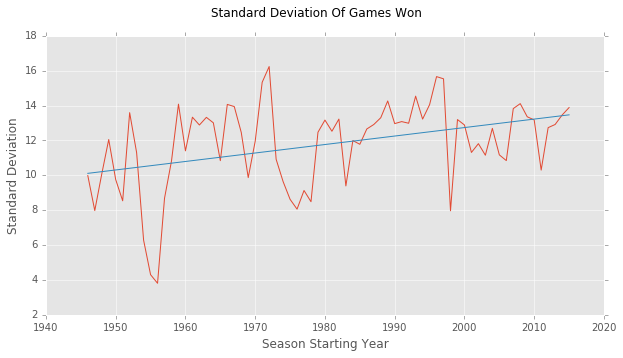

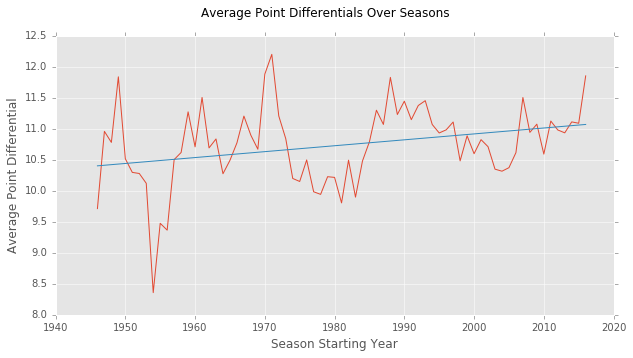

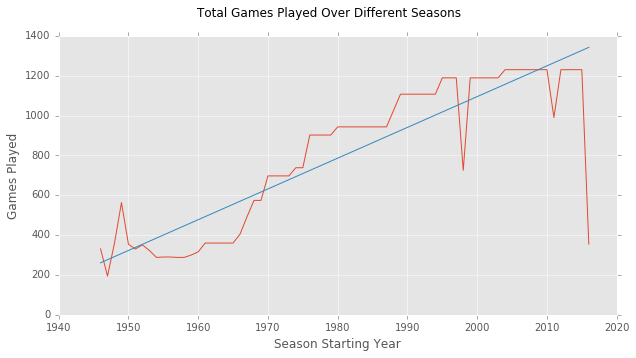

In [16]:
import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
def get_team_wins_count(league_df, team_id, season_id):
    """ Given a df containing ALL game logs (including home and away), 
        team_id and season_id, returns number of wins the team got that season
    Input:
        league_df (pandas.DataFrame): dataframe containing post-processed league logs (both HOME and AWAY)
        team_id (int or string): player ID number
        season_id (int or string): season ID number
    Output:
        (int): number of games team won in season
    """ 
    team_id = int(team_id)
    season_id = str(season_id)
    
    temp_df = league_df[(league_df['season_id'] == season_id) & (league_df['team_id'] == team_id)]
    temp_df = temp_df.sort_values('game_date')
    
    # get last game
    last_game = temp_df.iloc[len(temp_df) - 1]

    wins = 0
    games_won_so_far = 0
    if last_game['is_home']:
        games_won_so_far = int(round(last_game['home_win_pct']*last_game['home_game_count']))
    else:
        games_won_so_far = int(round(last_game['away_win_pct']*last_game['away_game_count']))
    wins = games_won_so_far + last_game['wl_binary']
    return wins
    
get_team_wins_count(all_games, "1610612742", "22004")

def graph_stdev_wins(league_df):
    """ Given a df containing ALL SORTED game logs (including home and away), 
        graphs stdev of team wins over time
    Input:
        league_df (pandas.DataFrame): dataframe containing post-processed league logs (both HOME and AWAY)
    Output:
        None
    """
    season_list = league_df['season_id'].unique().tolist()
    seasons = []
    stdevs = []
    for season in season_list:
        season_df = league_df[league_df['season_id'] == season]
        team_list = season_df['team_id'].unique().tolist()
        win_counts = []
        for team in team_list:
            team_wins = get_team_wins_count(league_df, team, season)
            win_counts.append(team_wins)
        stdev = np.array(win_counts).std(ddof = 1)
        seasons.append(int(season[1:]))
        stdevs.append(stdev)
        
    # remove last, unfinished year
    seasons = seasons[:len(seasons)- 1]
    stdevs = stdevs[:len(stdevs) - 1]
    fig = plt.figure()
    fig.suptitle('Standard Deviation Of Games Won',fontsize=12)
    plt.xlabel('Season Starting Year')
    plt.ylabel('Standard Deviation')
    plt.plot(seasons, stdevs, seasons, 
                  np.poly1d(np.polyfit(seasons, stdevs, 1))(np.unique(seasons)))
         
graph_stdev_wins(all_games)

def graph_avg_ptdiff(league_df):
    """ Given a df containing ALL SORTED game logs (including home and away), 
        graphs average (absolute value) ptdiff over seasons
    Input:
        league_df (pandas.DataFrame): dataframe containing post-processed league logs (both HOME and AWAY)
    Output:
        None
    """
    season_list = league_df['season_id'].unique().tolist()
    seasons = []
    avg_pt_diffs = []
    for season in season_list:
        season_df = league_df[league_df['season_id'] == season]
        pt_diff = season_df['plus_minus'].values
        pt_diff = np.apply_along_axis(lambda x: np.abs(x), 0, pt_diff)
        seasons.append(int(season[1:]))
        avg_pt_diffs.append(np.mean(pt_diff))
    fig = plt.figure()
    fig.suptitle('Average Point Differentials Over Seasons',fontsize=12)
    plt.xlabel('Season Starting Year')
    plt.ylabel('Average Point Differential')
    plt.plot(seasons, avg_pt_diffs, seasons, 
                  np.poly1d(np.polyfit(seasons, avg_pt_diffs, 1))(np.unique(seasons)))

graph_avg_ptdiff(all_games)
    
def total_games_graph(league_df):
    """ Given a df containing ALL HOME game logs, 
        graphs total games played throughout seasons
    Input:
        league_df (pandas.DataFrame): dataframe containing post-processed league logs (only HOME)
    Output:
        None
    """
    season_list = league_df['season_id'].unique().tolist()
    seasons = []
    total_games = []
    for season in season_list:
        season_df = league_df[league_df['season_id'] == season]
        seasons.append(int(season[1:]))
        total_games.append(len(season_df))
    fig = plt.figure()
    fig.suptitle('Total Games Played Over Different Seasons',fontsize=12)
    plt.xlabel('Season Starting Year')
    plt.ylabel('Games Played')
    plt.plot(seasons, total_games, seasons, 
                  np.poly1d(np.polyfit(seasons, total_games, 1))(np.unique(seasons)))
    
total_games_graph(home_games)

The first two plots show that the standard deviation of games won and average point differentials have wave-like patterns that are only slowly increasing as a whole. The increasing trend of the standard deviation of the number of games won demonstrates a larger spread of games won, perhaps indicating larger gaps between good and bad teams in the league. This could possibly be due to the increasing number of teams in the league. Similarly, the increasing trend in average point differential also supports this idea of a larger gap between good and bad teams, as average point differentials are larger in recent seasons. 

These effects, however, do not seem particularly large, as the overall increase for the standard deviation of games won and average point differential are 4 and 0.5, respectively.

We notice a larger effect in the total games played. The number of games has been increasing from seasons 1940-1990; afterwards it levels off. The last point on the graph represents the current season, which is still in progress. Years 1989 and 2011 show dips in the plot due to being lockout seasons, resulting in condensed schedules. This is important in considering which seasons to include in our data. Seasons 1990 and after are a lot more similar to the number of total games played currently, while going back each year becomes increasingly different.

<a id='Feature Selection'></a>
## 4. Feature Selection
Now that we have done some initial data analysis, we would like to fine tune a couple of our features. Specifically, we tune our training cutoffs and N-parameter. 

<a id='Training Cutoff'></a>
### 4A. Training Cutoff

While we have data on the running home win percentage for any particular season, we still have to take caution about games that are played at the beginning of the season. When there are not many games yet played, the home win percentage can flucuate wildly (i.e 100% to 50% to 66%). To prevent some of the noise in these particular features, we would like to cut off some games at the start of the season. To determine the cutoff, we plot the change in home-win-percentage against the number of games played. To get a sufficient sample size, we use all seasons 1947-present.

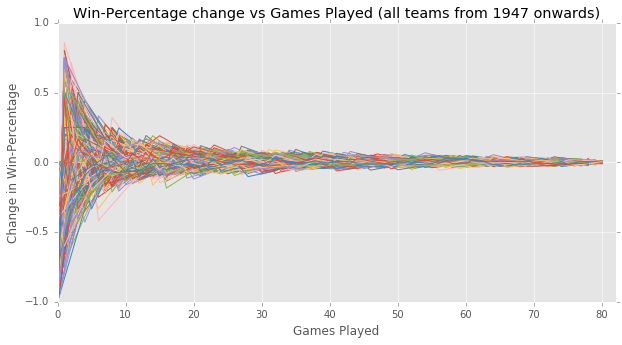

In [17]:
def check_cutoff_value(df):
    """ Given a dataframe of game logs, display a graph showing the change 
        in win percentage per team as a season progresses
    Input:
        df (pd.DataFrame): Game_log
    Output:
        (None)
    """
    all_years_id = home_games["season_id"].unique()
    for year in all_years_id:
        curr_year = home_games[(home_games["season_id"] ==year)]
        all_teams = curr_year["team_abbreviation"].unique()
        for team in all_teams:
            newdf = curr_year[(curr_year["team_abbreviation"] ==team)]
            temp = newdf['home_win_pct'] - newdf['home_win_pct'].shift(-1) # difference in win_pct
            plt.plot(newdf["home_game_count"],temp)
    plt.axis([0,82,-1,1])
    plt.xlabel('Games Played')
    plt.ylabel('Change in Win-Percentage')
    plt.title('Win-Percentage change vs Games Played (all teams from 1947 onwards)')

check_cutoff_value(home_games)

We decide on a cutoff of N = 10. This allows us to discount the first couple of "inaccurate" win-percentages yet still leave us with enough games to train on in a particular season.

<a id='N-Previous Games'></a>
### 4B. Lookback Parameter (N) Tuning
A crucial parameter in our model is our lookback parameter, which is used in the calcation of the `home_win_pct_N` and `away_win_pct_N` features. The idea behind these features is that team performance may be streaky. Further, team dynamics change throughout the season, i.e. through injuries and roster changes. Thus, it is important to not only consider team performance throughout the entire season, but also the recent team performance.

Given our current model, we compare using different N values and do comparisons between the results. We note that this approach was inspired from work from Amorim Torres [1]. 

In [19]:
# Use svg backend for better quality
import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

def add_lookback_features(league_df, params):
    """ Given a dataframe league_df and a list of natural numbers params, returns a new df containing 
        extra columns for each lookback parameter in params.
    Input:
        league_df (pandas.DataFrame): dataframe containing league logs
        params (list): list containing positive integers
    Output:
        pd.DataFrame
    """ 
    
    # Ensure correct params formatting
    for i in params:
        assert (type(i) == int and i > 0)
        
    new_df = league_df.sort_values('game_date')
    
    # Initialize new columns
    for i in params:
        lookback = i
        
        home_col_name = 'home_win_pct_' + str(i)
        away_col_name = 'away_win_pct_' + str(i)
        
        new_df.loc[:,home_col_name] = np.zeros(len(new_df))
        new_df.loc[:,away_col_name] = np.zeros(len(new_df))
        
        grouped = new_df.groupby(['season_id'])
        groupList = [grouped.get_group(x) for x in grouped.groups]

        for season_df in groupList:
            # Initialize dictionary containing wins and losses for each team
            running_dict = dict()

            for team in season_df['team_id'].unique():
                running_dict[team] = []

            # Sort season by day
            season_df = season_df.sort_values('game_date')

            seen_games = set()
            
            for (index, row) in season_df.iterrows():
                team_id = row['team_id']
                opp_team_id = row['opp_team_id']
                wl = row['wl']
                game_id = row['game_id']
                is_home = row['is_home']
                
                if is_home == 1:
                    home_team_id = team_id
                    away_team_id = opp_team_id
                else:
                    home_team_id = opp_team_id
                    away_team_id = team_id
                
                # Update home_win_pct_N, away_win_pct_N
                home_win_pct_N = 0
                away_win_pct_N = 0
                
                home_games_count = len(running_dict[home_team_id])
                away_games_count = len(running_dict[away_team_id])

                if home_games_count > 0:
                    if home_games_count > lookback:
                        lookback_games = running_dict[home_team_id][home_games_count - lookback:]
                    else:
                        lookback_games = running_dict[home_team_id]
                    home_win_pct_N = sum(lookback_games)/float(len(lookback_games))

                if away_games_count > 0:
                    if away_games_count > lookback:
                        lookback_games = running_dict[away_team_id][away_games_count - lookback:]
                    else:
                        lookback_games = running_dict[away_team_id]
                    away_win_pct_N = sum(lookback_games)/float(len(lookback_games))

                new_df.set_value(index, home_col_name, home_win_pct_N)
                new_df.set_value(index, away_col_name, away_win_pct_N)
                
                # Update running stats
                if (wl == 'W'):
                    if game_id in seen_games:
                        running_dict[team_id].append(1)
                        running_dict[opp_team_id].append(0)

                else:
                    if game_id in seen_games:
                        running_dict[opp_team_id].append(1)
                        running_dict[team_id].append(0)
                        
                seen_games.add(game_id)
    return new_df

def graph_lookback(league_df, params):
    """ Given a dataframe league_df, a season_id, and a list of natural numbers params, graphs the effectiveness
        of using each of the params as a naive classifier
    Input:
        league_df (pandas.DataFrame): dataframe containing league logs, including the lookback columns from params
        season_id (str): season identifier
        params (list): sorted list containing positive integers
    Output:
        None
    """ 
    grouped = league_df.groupby(['season_id'])
    groupList = [grouped.get_group(x) for x in grouped.groups]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    for season_df in groupList:
        # Initialize dictionary counting number of correct classifications for each param i
        correct_dict = dict()

        for i in params:
            correct_dict[i] = 0

        # Sort season by day
        season_df = season_df.sort_values('game_date')

        #seen_games = set()
        
        season_id = ""

        for (index, row) in season_df.iterrows():
            team_id = row['team_id']
            opp_team_id = row['opp_team_id']
            wl = row['wl_binary']
            game_id = row['game_id']
            is_home = row['is_home']
            season_id = row['season_id']
            
            
            for i in params:
                home_col_name = 'home_win_pct_' + str(i)
                away_col_name = 'away_win_pct_' + str(i)
                
                home_pct = row[home_col_name]
                away_pct = row[away_col_name]
                
                if (is_home == 1 and wl == 1 and home_pct >= away_pct):
                    correct_dict[i] += 1
                elif (is_home == 1 and wl == 0 and away_pct > home_pct):
                    correct_dict[i] += 1
                elif (is_home == 0 and wl == 1 and away_pct > home_pct):
                    correct_dict[i] += 1
                elif (is_home == 0 and wl == 0 and home_pct >= away_pct):
                    correct_dict[i] += 1
                    
        pct_list = []
        for i in params:
            pct_list.append(correct_dict[i]/float(len(season_df)))
            
        ax.plot(params, pct_list, label = season_id[1:])
        
    ax.set_xlabel("Lookback Parameter (N)", fontsize=15)
    ax.set_ylabel("Classification Accuracy", fontsize=18)
    
    fig.suptitle('Classification Accuracy Using Different Lookback Parameters', fontsize = 18)
    
    ax.legend(loc="upper left", bbox_to_anchor=(1,1))
        
    plt.plot()
    

In [ ]:
all_games_lookback = add_lookback_features(all_games, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
all_games_lookback.tail()

In [ ]:
temp_df = all_games_lookback[all_games_lookback["season_id"] >= "22004"]
graph_lookback(temp_df, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

Based off of the above graph, and prediction accuracies for each model (done below), we decide that the best option is N=11.

<a id='Additional Features'></a>
## 5. Additional Features
While building our model, we decided to add additional features that could be possibly significant in predicting win/losses. Both of these features are implemented in [fivethirtyeight's](http://fivethirtyeight.com/features/how-our-2015-16-nba-predictions-work/) 2015-16 NBA prediction model.

<a id='Altitude'></a>
### 5A. Altitude
A potiential feature is the altitude of the stadium. The Denver Nuggets and Utah Jazz have stadiums that are at very high elevations (5280 ft and 4226 ft, respectively). At these elevations, the vistor teams have a possible disadvantage due to the fact they are not accustomed to lower oxygen levels. While this hypothesis is debated, it is true that the home team consistently has a larger home court advantage compared to other teams.

Since there are currently only 30 teams, it was simpler to manually check elevations at each stadium. Below we insert the altitude column in the dataframe.

In [ ]:
#temp_df = home_games_with_cutoff[home_games_with_cutoff['season_id']>="22005"]
temp_df = all_games[all_games['season_id'] >= '22005']
#temp_df = new_years_df[new_years_df['is_home'] == 1]

temp_df.head()
altitude = {'Chicago Stags': 615, 'Buffalo Braves': 600, 'Washington Bullets': 400, 'Toronto Huskies': 249, 
            'Los Angeles Lakers': 233, 'Chicago Bulls': 615, 'Washington Capitols': 200, 'Providence Steamrollers': 75, 
            'Charlotte Bobcats': 751, 'Capital Bullets': 200, 'New Orleans Pelicans': 13, 'San Diego Rockets': 62, 
            'Milwaukee Hawks': 617, 'Philadelphia 76ers': 39, 'Philadelphia Warriors': 39, 'Chicago Packers': 615, 
            'New Orleans Jazz': 20, 'Detroit Pistons': 961, 'Boston Celtics': 141, 'Miami Heat': 24, 
            'Minneapolis Lakers': 830, 'Orlando Magic': 82, 'Portland Trail Blazers': 50, 'Rochester Royals': 505, 
            'Golden State Warriors': 43, 'Sheboygan Redskins': 630, 'New York Knicks': 33, 'St. Louis Hawks': 465, 
            'Indianapolis Olympians': 715, 'Washington Wizards': 205, 'Kansas City Kings': 910, 'Utah Jazz': 4226, 
            'Ft. Wayne Zollner Pistons': 600, 'Pittsburgh Ironmen': 1365, 'New Jersey Nets': 33, 'New York Nets': 33, 
            'Dallas Mavericks': 430, 'Sacramento Kings': 30, 'New Orleans/Oklahoma City Hornets': 20, 
            'Los Angeles Clippers': 305, 'San Antonio Spurs': 650, 'Vancouver Grizzlies': 171, 
            'Oklahoma City Thunder': 1201, 'Waterloo Hawks': 1079, 'Charlotte Hornets': 751, 'Anderson Packers': 879, 
            'Syracuse Nationals': 380, 'Kansas City-Omaha Kings': 910, 'Cincinnati Royals': 482, 'Cleveland Rebels': 653, 
            'Milwaukee Bucks': 617, 'Phoenix Suns': 39, 'LA Clippers': 305, 'Memphis Grizzlies': 337, 
            'Tri-Cities Blackhawks': 1050, 'Toronto Raptors': 249, 'Houston Rockets': 43, 'New Orleans Hornets': 13, 
            'Chicago Zephyrs': 594, 'Minnesota Timberwolves': 830, 'Detroit Falcons': 600, 'Indiana Pacers': 715, 
            'San Diego Clippers': 62, 'Seattle SuperSonics': 518, 'Cleveland Cavaliers': 653, 'Atlanta Hawks': 1050, 
            'Brooklyn Nets': 33, 'Indianapolis Jets': 715, 'Baltimore Bullets': 480, 'San Francisco Warriors': 52, 
            'St. Louis Bombers': 465, 'Denver Nuggets': 5280}
altitude_dict = {}
curr_names = temp_df["team_name"].tolist()
for key in altitude:
    if key not in curr_names:
        continue
    else:
        filtered_df = temp_df[temp_df['team_name'] == key]
        cor_id = filtered_df["team_id"].iloc[0]
        altitude_dict[str(cor_id)] = altitude[key]
### adding a new elevation column
elevation = np.zeros(len(temp_df), dtype = np.int64)
temp_df = temp_df.assign(elevation = elevation)

for (index, row) in temp_df.iterrows():
        location = row['is_home']
        if location == 1: # at home
            alt = altitude_dict[str(row["team_id"])]
            temp_df.set_value(index, 'elevation', alt)
        else:
            alt = altitude_dict[str(row["opp_team_id"])]
            temp_df.set_value(index, 'elevation', alt)
temp_df.head()

<a id='Travel Distance'></a>
### 5B. Travel Distance (2005+)
Another potential useful feature is the distance traveled by a team to get to the current location. This is related to fatigue, as teams will likely be tired from flights, and time zone changes can be distorting. We will add features `home_mileage` and `away_mileage`, indicating the number of miles traveled to get to the current game.

To do this, we will use the library `geopy` to get coordinates and calculate distances (distance will be calculated using the vincenty formula). We will manually create dictionaries mapping teams to locations, limiting our year scope to include only 2005+ for convenience. We do not think this limitation will be significant since we know that recent years are the most important.

In [ ]:
from geopy.geocoders import Nominatim
from geopy.distance import vincenty

# Only consider years after 2005
#temp_df = all_games[all_games['season_id'] >= '22005']
team_names = temp_df['team_name'].unique().tolist()
#print len(team_names), team_names

team_id_list = temp_df['team_id'].unique().tolist()

# Dictionary mapping of team_id to team_name
id_team = dict()
for team_id in team_id_list:
    temp_df_1 = temp_df[temp_df['team_id'] == team_id]
    id_team[team_id] = temp_df_1['team_name'].unique().tolist()

# Dictionary mapping of team_name to seasons
team_seasons = dict()
for team_name in team_names:
    temp_df_1 = temp_df[temp_df['team_name'] == team_name]
    team_seasons[team_name] = temp_df_1['season_id'].unique().tolist()

# Dictionary mapping team name to location
name_location = {'Dallas Mavericks': 'Dallas, Texas',
                'New Orleans/Oklahoma City Hornets': 'Oklahoma City, Oklahoma',
                'Milwaukee Bucks': 'Milwaukee, Wisconsin',
                'San Antonio Spurs': 'San Antonio, Texas',
                'Philadelphia 76ers': 'Philadelphia, Pennsylvania',
                'Phoenix Suns': 'Phoenix, Arizona',
                'Denver Nuggets': 'Denver, Colorado',
                'Sacramento Kings': 'Sacramento, California',
                'Atlanta Hawks': 'Atlanta, Georgia',
                'Miami Heat' : 'Miami, Florida', 
                'Toronto Raptors': 'Toronto, Ontario', 
                'New Jersey Nets': 'Newark, New Jersey', 
                'Houston Rockets': 'Houston, Texas', 
                'Boston Celtics': 'Boston, Massachusetts', 
                'Golden State Warriors' : 'Oakland, California', 
                'Utah Jazz': 'Salt Lake City, Utah', 
                'Seattle SuperSonics' : 'Seattle, Washington', 
                'Portland Trail Blazers': 'Portland, Oregon', 
                'Indiana Pacers' : 'Indianapolis, Indiana', 
                'Minnesota Timberwolves' : 'Minneapolis, Minnesota', 
                'Washington Wizards': 'Washington D.C., Virginia',
                'Chicago Bulls' : 'Chicago, Illinois', 
                'New York Knicks': 'New York City, New York', 
                'Cleveland Cavaliers' : 'Cleveland, Ohio', 
                'Charlotte Bobcats' : 'Charlotte, North Carolina',
                'Detroit Pistons' : 'Detroit, Michigan', 
                'Memphis Grizzlies' : 'Memphis, Tennessee', 
                'Orlando Magic' : 'Orlando, Florida', 
                'Los Angeles Clippers' : 'Los Angeles, California', 
                'Los Angeles Lakers' : 'Los Angeles, California', 
                'New Orleans Hornets' : 'New Orleans, Louisiana', 
                'Oklahoma City Thunder': 'Oklahoma City, Oklahoma', 
                'Brooklyn Nets': 'Brooklyn, New York', 
                'New Orleans Pelicans' : 'New Orleans, Louisiana', 
                'Charlotte Hornets' : 'Charlotte, North Carolina', 
                'LA Clippers' : 'Los Angeles, California'}

# Dictionary mapping location to (latitude, longitude)
location_latlong = dict()
geolocator = Nominatim()
for key,value in name_location.iteritems():
    geo_loc = geolocator.geocode(value)
    (lat1, long1) = (geo_loc.latitude, geo_loc.longitude)
    location_latlong[value] = (lat1,long1)
    
def get_team_location(team_id, season_id):
    """ Given a team id and the season_id, returns a string containing the location of the team stadium
    Input: 
        team_id (int): team id
        season_id (str): season id 
    Output:
        (str) 
    """
    names = id_team[team_id]
    
    team_name = None
    
    for name in names:
        seasons = team_seasons[name]
        #print seasons, name
        if season_id in seasons:
            team_name = name
            
    if team_name == None:
        print (team_id, season_id, names)
        assert(False)
    
    return name_location[team_name]

def add_mileage(league_df):
    geolocator = Nominatim()
    seen_distances = dict()
    
    new_df = league_df.sort_values('game_date')
    home_mileage = np.zeros(len(new_df))
    away_mileage = np.zeros(len(new_df))
    
    new_df = new_df.assign(home_mileage = home_mileage)
    new_df = new_df.assign(away_mileage = away_mileage)
    

    home_mileage = np.zeros(len(new_df))
    away_mileage = np.zeros(len(new_df))
    
    # Ddd features
    grouped = new_df.groupby(['season_id'])
    groupList = [grouped.get_group(x) for x in grouped.groups]
    
    for season_df in groupList:
        running_locations = dict()
        
        for team in season_df['team_id'].unique():
            # track list of locations played at
            running_locations[team] = []
        
        # sort season by day
        season_df = season_df.sort_values('game_date')
        
        seen_games = set()
        
        for (index, row) in season_df.iterrows():
            is_home = row['is_home']
            team_id = row['team_id']
            opp_team_id = row['opp_team_id']
            game_id = row['game_id']
            season_id = row['season_id']
            
            if is_home == 1:
                home_team_id = team_id
                away_team_id = opp_team_id
            else:
                home_team_id = opp_team_id
                away_team_id = team_id
                
            
            home_games_count = row['home_game_count']
            away_games_count = row['away_game_count']
            
            home_mileage = 0
            away_mileage = 0
            
            curr_location = get_team_location(home_team_id, season_id)

            (curr_lat, curr_long) = location_latlong[curr_location]

            if home_games_count > 0:
                location_list = running_locations[home_team_id]
                assert(len(location_list) == home_games_count)
                last_location = location_list[len(location_list) - 1]
                (last_lat, last_long) = location_latlong[last_location]

                str1 = curr_location + last_location
                str2 = last_location + curr_location

                if str1 in seen_distances:
                    home_mileage = seen_distances[str1]
                elif str2 in seen_distances:
                    home_mileage = seen_distances[str2]
                else:
                    home_mileage = vincenty((last_lat,last_long), (curr_lat,curr_long)).miles
                    seen_distances[str1] = home_mileage

            if away_games_count > 0:
                location_list = running_locations[away_team_id]
                assert(len(location_list) == away_games_count)
                last_location = location_list[len(location_list) - 1]

                (last_lat, last_long) = location_latlong[last_location]

                str1 = curr_location + last_location
                str2 = last_location + curr_location

                if str1 in seen_distances:
                    away_mileage = seen_distances[str1]
                elif str2 in seen_distances:
                    away_mileage = seen_distances[str2]
                else:
                    away_mileage = vincenty((last_lat,last_long), (curr_lat,curr_long)).miles
                    seen_distances[str1] = away_mileage

            new_df.set_value(index, 'home_mileage', home_mileage)
            new_df.set_value(index, 'away_mileage', away_mileage)
            
            if game_id in seen_games:
                running_locations[home_team_id].append(curr_location)
                running_locations[away_team_id].append(curr_location)
                
            seen_games.add(game_id)
            
    return new_df

In [ ]:
mileage_df = add_mileage(temp_df)#all_games[all_games['season_id']>='22005'])
mileage_df.head()

In [ ]:
cutoff = 10
df_with_elev_mileage = mileage_df
df_with_elev_mileage = df_with_elev_mileage[df_with_elev_mileage['is_home']==1]
df_with_elev_mileage_with_cutoff = df_with_elev_mileage[df_with_elev_mileage['home_game_count'] >= cutoff]
home_games_2005 = home_games[home_games['season_id'] >= '22005']
home_games_with_cutoff = home_games_2005[home_games_2005['home_game_count'] >= cutoff]


In [ ]:
#print home_games_with_cutoff.head()
#print df_with_elev_mileage_with_cutoff.head()
print len(home_games_with_cutoff)
print len(df_with_elev_mileage_with_cutoff)

<a id='Modeling'></a>
## 6. Modeling
We train our models on 2005-06 to 2009-10 (5 seasons - 5393 games) and we validate on 2010-11 to 2012-13 (3 seasons - 3450 games). Note that code for Linear Regression and Logistic Regression is in the R file.

<a id='Naive Approach'></a>
### 6A. Naive Approach
Choose the team with the better record so far. If the records are tied, choose the home team as the winner.

In [ ]:
def naive_approach_accuracy(home_games_df, season_id_list):
    """ Given a df containing ALL HOME game logs, 
        season_id, returns accuracy of naive classification
    Input:
        league_df (pandas.DataFrame): dataframe containing post-processed league logs (both HOME and AWAY)
        season_id (int or string): season ID number
    Output:
        (int): number of games team won in season
    """
    
    correct = 0
    total = 0
    
    for season_id in season_id_list:
        season_id = str(season_id)

        season_df = home_games_df[(home_games_df['season_id'] == season_id)]
        for (index, row) in season_df.iterrows():
            home_team_pct = row['home_win_pct']
            away_team_pct = row['away_win_pct']
            wl = row['wl_binary']
            classification = 0

            if (home_team_pct >= away_team_pct):
                classification = 1
            if classification == wl:
                correct += 1
            total += 1
        
    return correct/float(total)

print naive_approach_accuracy(home_games,["22010","22011","22012",])
    
def graph_naive(home_games_df):
    """ Given a df containing ALL HOME game logs, 
        graph_naive graphs the naive classification accuracy across seasons
    Input:
        home_games_df (pandas.DataFrame): dataframe containing post-processed 
            league logs (HOME)
    Output:
        None
    """
    season_list = home_games_df['season_id'].unique().tolist()
    seasons = []
    naives = []
    for season in season_list:
        season_df = league_df[league_df['season_id'] == season]
        naives.append(naive_approach_accuracy(home_games_df, [season]))
        #pt_diff = season_df['plus_minus'].values
        #pt_diff = np.apply_along_axis(lambda x: np.abs(x), 0, pt_diff)
        seasons.append(int(season[1:]))
        #avg_pt_diffs.append(np.mean(pt_diff))
    fig = plt.figure()
    fig.suptitle('Naive Classification Accuracy',fontsize=12)
    plt.xlabel('Season Starting Year')
    plt.ylabel('Accuracy')
    plt.plot(seasons, naives, seasons, 
                  np.poly1d(np.polyfit(seasons, naives, 1))(np.unique(seasons)))

graph_naive(home_games)

<a id='Linear Regression Model'></a>
### 6B. Linear Regression Model

Our first approach of modeling our features was to use a multivariate linear regression model.

$$y_{i} = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + ... + \theta_{n-1}x_{n-1}$$
More consisely,
$$ y_{i} = \sum_{i=1}^{n} \theta_{i} x_{i}$$

To predict `plus_minus`, we include the following features in our model:
- home_win_pct
- away_win_pct
- home_win_pct_N
- away_win_pct_N
- home_back_to_back
- away_back_to_back
- home_win_pct_as_home
- away_win_pct_as_away
- away_back_to_back*away_win_pct_as_away
- elevation
- elevation*home_win_pct_as_home

Note that we decided to not include certain features. We noticed that `home_avg_pt_diff` and `away_avg_pt_diff` both had very high multicollinearity (r-squared = 0.98) against `home_win_pct` and `away_win_pct`, repectively, we disregarded these features. `home_avg_pt_diff` and `away_avg_pt_diff`. We also disregard travel distance, as it did almost nothing in terms of accuracy on our validation set.
In addition we added interaction terms between `away_back_to_back` and `away_win_pct_as_away` as well as `elevation` and `home_win_pct_as_home`.
We checked that our model followed linear assumptions by checking residual plots against each feature as well as a Q-Q plot for normality assumptions. A lambda value of 1 in a boxcox shows that there is no need to transform our response variable.
<img src="resids2.png"> <img src="qqandboxcox.png">

Using Linear Regresion, we get an accuracy of 67.22% on our test set.

<a id='Logistic Regression Model'></a>
### 6C. Logistic Regression Model
Our second approach is using a binary logistic regression model. Our response variable is win or loss.

To predict win/loss, we use the following features:

- home_win_pct
- away_win_pct
- home_win_pct_N 
- away_win_pct_N
- home_back_to_back
- away_back_to_back
- home_win_pct_as_home
- away_win_pct_as_away
- away_back_to_back:away_win_pct_as_away
- elevation

Using Logistic Regression, we get an accuracy of 66.45% on our test set.

<a id='SVM'></a>
### 6D. Support Vector Machines

In addition to Linear and Logistic Regression, we to try support vector machines for classification of win-loss. We first normalize our data for cleaner modeling, and faster SVM convergence.

### Training, Validation, and Test Set Construction: 50-20-30 Split

In [ ]:
# home games
# divide into training set, validation set, test set

training_set = df_with_elev_mileage_with_cutoff[(home_games_with_cutoff['season_id'] >= "22005") & 
                                                (home_games_with_cutoff['season_id'] <= "22009")]
validation_set = df_with_elev_mileage[(home_games['season_id'] >= "22010") & 
                                      (home_games['season_id'] <= "22012")]
test_set = df_with_elev_mileage[(home_games['season_id'] >= "22013") & 
                                (home_games['season_id'] <= "22016")]

def normalize(df, param_labels):
    """ Given a df containing game logs to be normalized, returns a new normalized dataframe
    Input:
        df (pandas.DataFrame): dataframe containing post-processed league logs
        list (str): list of column labels to normalize
        soft (bool): whether to do soft normalization or hard normalization
    Output:
        pd.DataFrame
    """
    for label in param_labels:
        mean = np.mean(df[label])
        std = (df[label]).std()

        new_row = df[label].apply(lambda x: (x-mean)/(2*std))

        df.loc[:,label] = new_row 
    return df

# RUN THIS IF YOU WANT NORMALIZED STUFF
training_set = normalize(training_set, ['home_avg_pt_diff','away_avg_pt_diff', 'elevation','home_mileage','away_mileage'])
validation_set = normalize(validation_set, ['home_avg_pt_diff','away_avg_pt_diff','elevation','home_mileage','away_mileage'])
test_set = normalize(validation_set, ['home_avg_pt_diff','away_avg_pt_diff','elevation','home_mileage','away_mileage'])

#training_set = normalize(training_set, ['home_avg_pt_diff','away_avg_pt_diff', 'home_win_pct', "away_win_pct", 'home_win_pct_N', 'away_win_pct_N','away_win_pct_as_away',
            #'home_win_pct_as_home', 'home_back_to_back','away_back_to_back'])
#validation_set = normalize(validation_set, ['home_avg_pt_diff','away_avg_pt_diff', 'home_win_pct', "away_win_pct", 'home_win_pct_N', 'away_win_pct_N','away_win_pct_as_away',
            #'home_win_pct_as_home', 'home_back_to_back','away_back_to_back'])
#test_set = normalize(validation_set, ['home_avg_pt_diff','away_avg_pt_diff', 'home_win_pct', "away_win_pct", 'home_win_pct_N', 'away_win_pct_N','away_win_pct_as_away',
            #'home_win_pct_as_home', 'home_back_to_back','away_back_to_back'])

In [ ]:
def create_feature_matrix(df, features):
    """ Given a normalized df, returns a matrix of features and the binary w/l response
    Input:
        df (pandas.DataFrame): dataframe containing post-processed, normalzied league logs
        list (str): list of features to be included
    Output:
        (array-like, array-like)
    """
    return (df[features].values, df['wl_binary'].values)

# modify this as see fit
features = ['home_win_pct', 'away_win_pct',
           'home_win_pct_N', 'away_win_pct_N','away_win_pct_as_away',
            'home_win_pct_as_home', 'home_back_to_back','away_back_to_back','elevation','away_mileage']

training_matrix, training_response = create_feature_matrix(training_set, features)
validation_matrix, validation_response = create_feature_matrix(validation_set, features)

We ran SVM three different times on different parameters in order to test our results. We first ran SVC and used grid search to find optimal values for C and gamma, which we used the second time. Using the same C value, we found that the third SVM with squard hinge loss had the highest result.

In [ ]:
from sklearn.svm import LinearSVC, SVC
# Run SVM
clf = SVC(C=1e4, kernel='linear')
clf1 = SVC(C = 2**(3), gamma = 2**(-15), kernel = 'linear')
clf2 = LinearSVC(C=2**(3), loss='squared_hinge', dual = False, penalty = "l1", )

clf.fit(training_matrix, training_response)
clf1.fit(training_matrix, training_response)
clf2.fit(training_matrix, training_response)

In [ ]:
valid_pred = clf.predict(validation_matrix)
valid_pred2 = clf1.predict(validation_matrix)
valid_pred3 = clf2.predict(validation_matrix)

In [ ]:
import sys
def get_svm_accuracy(pred, actuals):
    """ Given predictions and actuals, calculates prediction accuracy
    Input:
        pred (array-like): list of predictions
        actuals (array-like): list of actual outputs
    Output:
        float
    """
    assert(len(pred) == len(actuals))
    correct = 0
    total = 0
    for i in xrange(len(pred)):
        if pred[i] == actuals[i]:
            correct += 1
        total += 1
    return correct/float(total)

print get_svm_accuracy(valid_pred, validation_response)
print get_svm_accuracy(valid_pred2, validation_response)
print get_svm_accuracy(valid_pred3, validation_response)

In [6]:
# Run grid search to find the optimal gamma and C values 
def gridSearch():
    cPower = -5
    bestC = 0
    bestG = 0
    optimal = sys.minint 
    for c in xrange(11):
        cVal = 2**(cPower)
        gPower = -15 
        for g in xrange(10):
            gVal = 2**(gPower)
            clf = SVC(C = cVal,gamma = gVal, kernel='linear')
            clf.fit(training_matrix, training_response)
            valid_pred = clf.predict(validation_matrix)
            currVal = get_svm_accuracy(valid_pred, validation_response)
            print currVal, gPower, cPower
            if optimal < currVal:
                optimal = currVal 
                bestC = cVal  
                bestG = gVal
            gPower += 2
        cPower += 2
    return (bestC, bestG)

#gridSearch()

Our best prediction accuracy for SVM turned out to be 66.29%.

<a id='Linear Regression Model'></a>
## 7. Final Results and Concluding Thoughts

<table>
  <tr>
    <th>Method</th>
    <th>Validation Accuracy Rate</th>
    <th>Test Set Accuracy Rate</th>
  </tr>
  <tr>
    <td>Naive Approach</td>
    <td>64.81%</td>
    <td>66.34%</td>
  </tr>
  <tr>
    <td>Linear Regression</td>
    <td>67.69%</td>
    <td>67.27%</td>
  </tr>
  <tr>
    <td>Logistic Regression</td>
    <td>67.15%</td>
    <td>66.45%</td>
  </tr>
  <tr>
    <td>Support Vector Machines</td>
    <td>67.19%</td>
    <td>66.29%</td>
  </tr>
</table>

Out of the three approaches, we determine that linear regression was the most accurate classifier. While our model beat the naive approach on the validation set by ~3%, we were only able to beat the naive approach on the test set by ~1%. We suspect that we may have overfit some of our parameters to our validation set.

In this report, we present novel approaches to incorporate altitude and travel mileage in machine learning models to predict NBA games. However, we found that these features were not able to significantly improve our predication accuracy, lending us to believe that the naive approach is more effective than initially anticipated.

In general, we found that, despite much parameter and feature tuning, it was very difficult to improve predication accuracy, which is potentially due to inherent unpredictability in NBA games. Nevertheless, we successfully determined that the effect of back-to-back games were statistically significant, while the effect of altitude and travel mileage was not.

## Further Studies

We suspect that there are approaches that could potentially improve our model. In this report, we found that proper modeling of player-specfic data such as injuries were difficult to effectively incorporate, though such could potentially improve predication accuracy. Further, certain parameters could be better tuned; for example, we could better track fatigue by including break day analysis.

Since we believe that predicting NBA game outcomes directly is difficult, we suggest the prediction of secondary behaviors, i.e. betting markets. Additionally, the collection of unique datasets (such as player tracking) could add a new dimension to our models.

Further studies could attempt to predict NBA playoff games, which we expect to behave differently than regular season games. For example, home court advantage may have a greater effect in the post-season, and the variability of team skill levels is smaller due to the fact that only 16 teams qualify. We could then also predict playoff series as a whole, which have their own dynamics as a best-of-seven series.

Another study would be to extend our approaches to study college basketball and March Madness, which may be very difficult due to its rapidly changing nature and frequent upsets.

### Sources
1. `http://homepages.cae.wisc.edu/~ece539/fall13/project/AmorimTorres_rpt.pdf`